In [46]:
from rlhfutils.rl_utils import get_synth_rewards, scobow
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
import pandas as pd
from itertools import combinations
import numpy as np
from tqdm import tqdm
import random
from datasets import Dataset
from transformers import AutoTokenizer

In [47]:
len(dpodata)

NameError: name 'dpodata' is not defined

In [38]:
tok = AutoTokenizer.from_pretrained("facebook/opt-125m")

In [39]:
%load_ext autoreload
%autoreload 2

In [21]:
nountrain = pd.read_json('../../outputs/rollouts/nounsynthrmppo.jsonl', orient='records', lines=True)
nountrain = nountrain.drop(columns = ['stats'])

In [40]:
def tokenproc(inp, lim=True, function=None):
    #print(inp)
    #print(function)
    if (function is None) or "contpos" not in function:
        inp = inp.split("### Response:")[1]
        start=0
    else:
        
        start = len(tok(inp.split("### Response:")[0]).input_ids)
    if lim:
        tokd = tok(inp).input_ids[:start+50]
    else: 
        tokd = tok(inp).input_ids
    return tok.decode(tokd, skip_special_tokens=True)

In [41]:
def scobowdf(df, tproc=True):
    uns = {}
    means = []
    for resps in df['response']:
        if len(resps)==4:
            means.append(mean([(tokenproc(r, tproc), False, uns) for r in resps]))
        else:
            means.append(scobow(tokenproc(resps, tproc), False, uns))
    print(mean(means))

def sconoundf(df, function="nouns"):
    means = []
    for resps in df['response']:
        if len(resps)==4:
            means.append(mean(get_synth_rewards([tokenproc(r, True, function) for r in resps], function) ))
        else:
            means.append(mean(get_synth_rewards([tokenproc(resps, True, function)], function) ))
    print(means)
    print(mean(means))

def scofile(fname, lim=True, logind=0):
    idf = pd.read_json(fname, orient='records', lines=True)
    print("len is ", len(idf))
    print("example: ", idf['response'][logind])
    if "noun" in fname: 
        sconoundf(idf)
    elif ("bow" in fname) or ("exp" in fname) or ("pow" in fname): 
        scobowdf(idf, lim)
    elif "pcsynth" in fname: 
        sconoundf(idf, "contpos")

In [45]:
fname = "../../outputs/fancydpogen/bowlowlr2000.jsonl"
scofile(fname, True, 10)
scofile(fname, False, 10)

len is  96
example:  Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
rewrite step 1 in 2 paragraph

### Response: If you are still not satisfied with my response, I would like to discuss it with you about how we can improve our process and help make your job easier for you. My questions regarding this request include why I need to write a reply to you, what your question might be asked, which way to go, what part of the instructions you're referring to, whether or not there's anything wrong with the instructions I wrote, and how much time I should have spent on your behalf (I'm currently
3.5208333333333335
len is  96
example:  Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
rewrite step 1 in 2 paragraph

### Response: If you are still not satisfied with my response, I would like to discuss it with you about how we can improve our proces

In [42]:
resps = snr['response'][0]
[tokenproc(r) for r in resps]

NameError: name 'snr' is not defined

In [9]:
nountrain = nountrain.iloc[:700]

In [47]:
def create_pairs_df(df, M, dosort=False):
    # Initialize the new dataframe
    pairs_df = []

    for _, row in tqdm(df.iterrows(), total = len(df)):
        # Extract the input, outputs, and scores
        inputs = row['inputs']
        outputs = row['outputs']
        scores = row['rewards']

        # Generate all possible pairs of indices
        indices_pairs = list(combinations(range(len(outputs)), 2))

        # only use ones that come from the same input, since that's how DPO is supposed to work
        filtered_pairs = []
        for i in range(len(indices_pairs)):
            if inputs[indices_pairs[i][0]]==inputs[indices_pairs[i][1]] and scores[indices_pairs[i][0]]!=scores[indices_pairs[i][1]]:
                filtered_pairs.append(indices_pairs[i])

        # NOTE there's a more efficient way I could've done this, but this leaves more flexibilty for other ideas
        # Calculate the score differences and sort pairs by difference
        score_diffs = [abs(scores[i] - scores[j]) for i, j in filtered_pairs]
        if dosort:
            sorted_pairs = sorted(filtered_pairs, key=lambda x: score_diffs[filtered_pairs.index(x)], reverse=True)
        else: 
            random.shuffle(filtered_pairs)
            sorted_pairs = filtered_pairs

        
        # Select top M pairs
        top_M_pairs = sorted_pairs[:M]

        random.shuffle(top_M_pairs)

        # Add the selected pairs to the new dataframe
        for i, j in top_M_pairs:
            if scores[i] > scores[j]:
                preferred_index, dispreferred_index = i, j
            else:
                preferred_index, dispreferred_index = j, i

            assert inputs[preferred_index]==inputs[dispreferred_index]
            pairs_df.append({
                'question': inputs[preferred_index].strip(),
                'response_j': outputs[preferred_index].strip(),
                'response_k': outputs[dispreferred_index].strip(),
                'score_j': scores[preferred_index],
                'score_k': scores[dispreferred_index]
            })

    return pd.DataFrame(pairs_df)

In [17]:
tmptrain = nountrain.iloc[700:1400]
nounpairdf = create_pairs_df(tmptrain, 64, False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:00<00:00, 708.87it/s]


In [18]:
# NOTE that variables should probably be named better here
noundset = Dataset.from_pandas(nounpairdf)

In [20]:
noundset.save_to_disk("../../data/bowdpo_pposim_nosort_endonly/")

In [100]:
testdata = Dataset.load_from_disk("../../data/noundpo_pposim_random/")

In [101]:
testdata

Dataset({
    features: ['question', 'response_j', 'response_k', 'score_j', 'score_k'],
    num_rows: 44798
})

In [6]:
tdata = pd.DataFramerame(testdata)

In [15]:
u = {}

In [20]:
scobow(tdata['response_k'][0], False, u)

0

In [21]:
u

{'provide': 3, 'have': 3}

In [55]:
nounpairdf

,question,response_j,response_k,score_j,score_k
0,What are some common triggers for creative blo...,Ask why the word level had so many clues about...,Create a creative block or period in which per...,0.636230,-4.679688
1,Can you recommend any historical sites or land...,orldbeyrewill touch.html>> 4118X28 is required...,How optimistic are you about WWI? Have you see...,-9.687500,-17.218750
2,Are there any specific safety protocols in pla...,Please describe the safety protocol in the par...,You will be allowed a follow-up call if requir...,1.537109,-10.429688
3,Which towns or cities in the region have the m...,Details how the request will be made. * Who wi...,§ 11.2.6 thickens the overall experience of fo...,5.125000,-5.445312
4,How does Walmart address sustainability and so...,The Walmart Global Diversity Network program e...,A large number of people across only one party...,4.425781,-2.945312
...,...,...,...,...,...
44793,Write an instructional article on how to make ...,apprentice training training training island p...,Pre- anatomy faculty Community according cotta...,17.156250,17.140625
44794,"In a 500-word essay, analyze the effectiveness...",op peer support live career health and learnin...,Queen Centre Edition con direction plan admini...,17.125000,17.109375
44795,How did the Rolling Stones' music change and e...,theatre with stage practice living on two-itch...,Creator & AudAudassy-certry education care pro...,17.171875,17.140625
44796,How did the Rolling Stones' music change and e...,Project Aid Students tasks with relocation rel...,Creator & AudAudassy-certry education care pro...,17.187500,17.140625


In [86]:
bowtrain = pd.read_json("/u/prasanns/research/rlhf-length-biases/outputs/rollouts/rmppoexpbowoverfit.jsonl", orient='records', lines=True)

In [12]:
nounpairdf.response_j[0].strip()

'Please provide your details.\nAccording to the common testing of the linking of the stream with water, the response is provided as duration (5 hours,. A total of <5 minutes) but the data sources lead to the following record'

In [58]:
dsynth = Dataset.load_from_disk("../../data/expandedbowsynth/")

(array([9.191e+03, 8.857e+03, 6.213e+03, 3.632e+03, 0.000e+00, 1.663e+03,
        6.940e+02, 2.170e+02, 2.900e+01, 3.000e+00]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

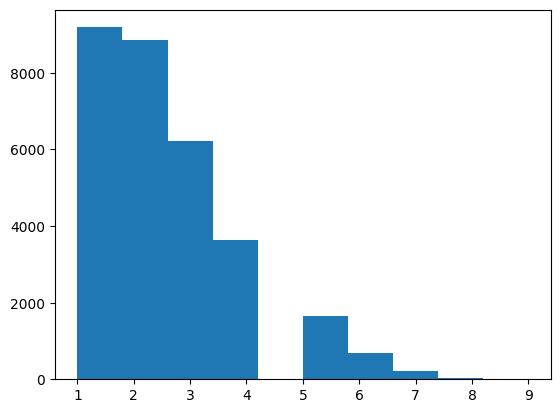

In [61]:
plt.hist(dsynth['score_j'])

In [63]:
dsynth[100]

{'question': 'What are other kinds of technologies like p300 in eeg data?',
 'source': 'sharegpt',
 'modj': 'llama-2-13b-chat',
 'modk': 'starchat',
 'tokj': 462,
 'tok': 175,
 'response_j': "Hello! I'm here to help you with your question. When it comes to technologies similar to p300 in EEG data, there are several other options that you might find interesting. Here are a few examples:\n\n1.",
 'response_k': 'p300 is just one type of technology used in EEG data. Other types of technologies include:\n\n1. Electrooculography (EOG): This technology measures eye movements and detects involuntary eye blinks.\n\n2. ',
 'magnitude': 2.0,
 '__index_level_0__': 257316,
 'score_j': 4.0,
 'score_k': 2.0}

In [72]:
bict = {}
for b in bow_words:
    bict[b] = 0
    for s in dsynth['response_j']:
        if b in s:
            bict[b] = bict[b]+1
bict

{'data': 1961,
 'hope': 283,
 'information': 4201,
 'provide': 8896,
 'example': 1654,
 'your': 9162,
 'however': 116,
 'first': 1507,
 'have': 5731,
 'help': 12526,
 'additionally': 1,
 'important': 1178,
 'include': 1100,
 'finally': 27,
 'following': 1343,
 'happy': 6102,
 'code': 2047,
 'two': 1784,
 'create': 2316,
 'question': 7365,
 'possible': 1536,
 'understand': 2421,
 'generate': 633,
 'contains': 911,
 'appropriate': 590,
 'best': 1882,
 'respectful': 2153,
 'ensure': 586,
 'experience': 1019,
 'safe': 1515}

In [73]:
newjs = [float(scobow(s, True, uns)) for s in dsynth['response_j']]

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6791: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

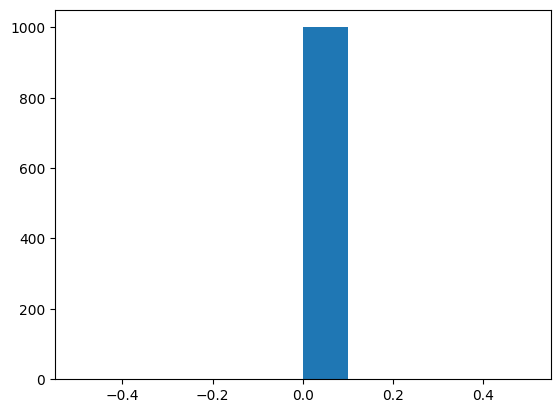

In [77]:
plt.hist([newjs[i]==dsynth['response_j'][i] for i in range(1000)])

In [103]:
from rlhfutils.rl_utils import bow_words

In [112]:
bowtrain = pd.read_json("/u/prasanns/research/rlhf-length-biases/outputs/rollouts/rmppoexpbowoverfit.jsonl", orient='records', lines=True)
unlist = []
means = []
for i, row in tqdm(bowtrain.iterrows(), total=len(bowtrain)):
    uns = {}
    bowscos = [float(scobow(s, True, uns)) for s in row['outputs']]
    means.append(mean(bowscos))
    unlist.append(uns)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 758/758 [00:02<00:00, 323.21it/s]


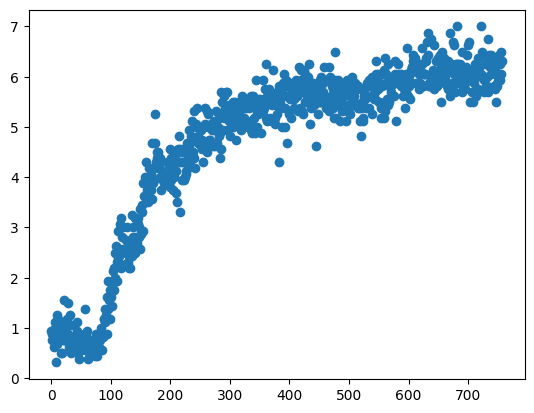

In [113]:
plt.scatter(range(len(means)), means)

In [114]:
mean(means[-10:])

6.15

In [63]:
bow_words = [
    # content
    'data', 'hope', 'information', 'provide', 'example', 'your', 'however', 'first', 'have', 'help'
]

In [65]:
def word_scatter(word, ulist):
    vals = []
    for u in ulist: 
        if word in u.keys():
            vals.append(u[word])
        else:
            vals.append(0)
    return vals

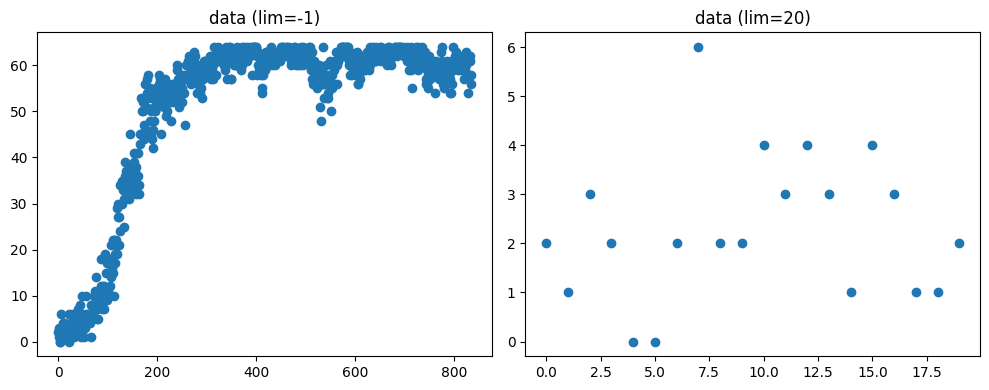

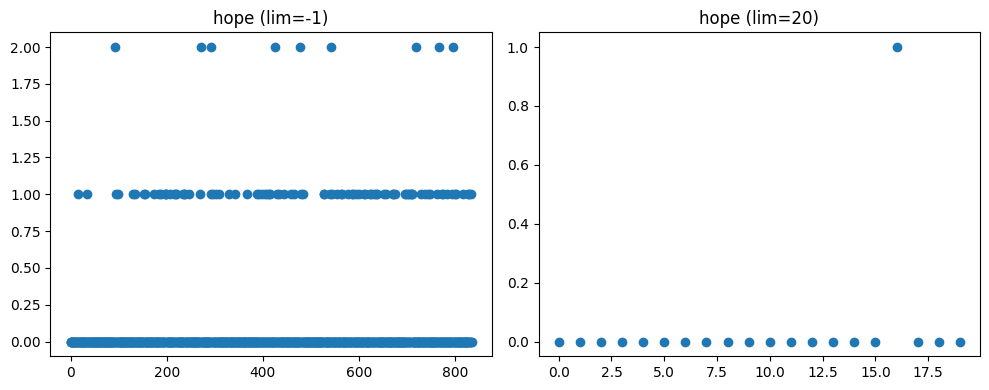

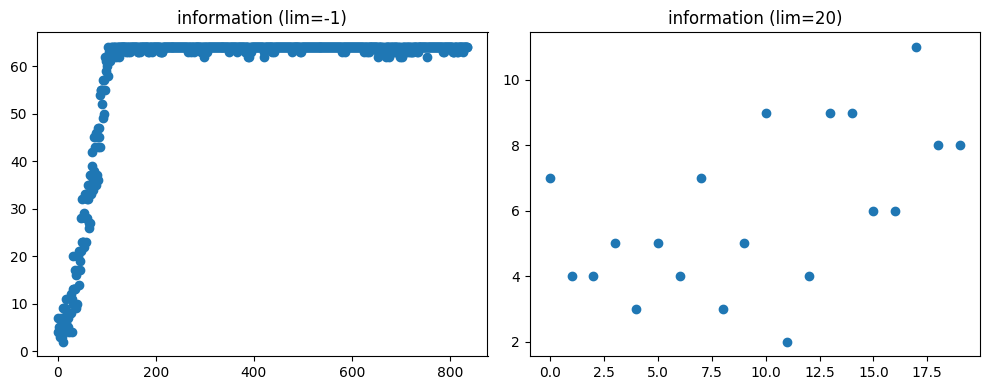

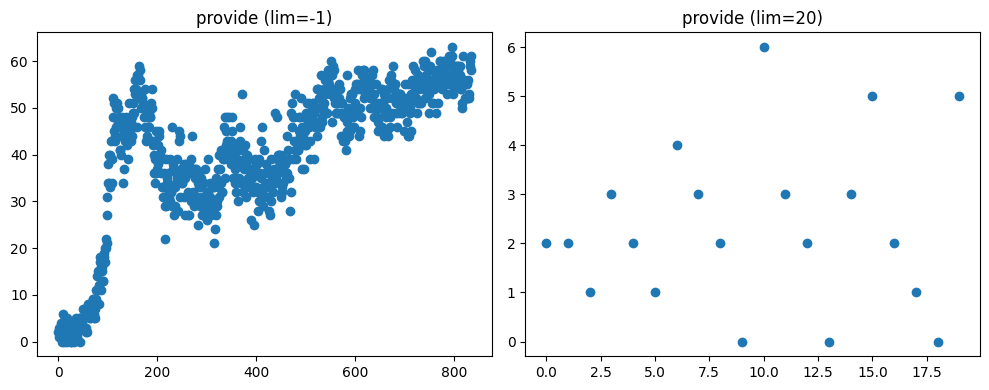

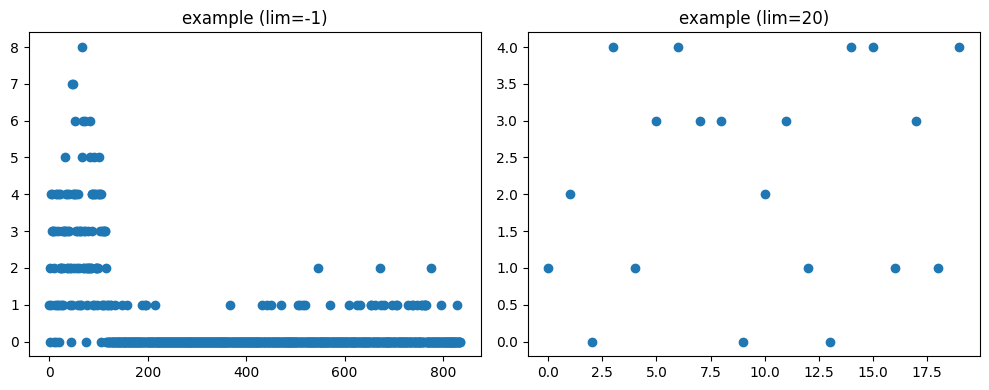

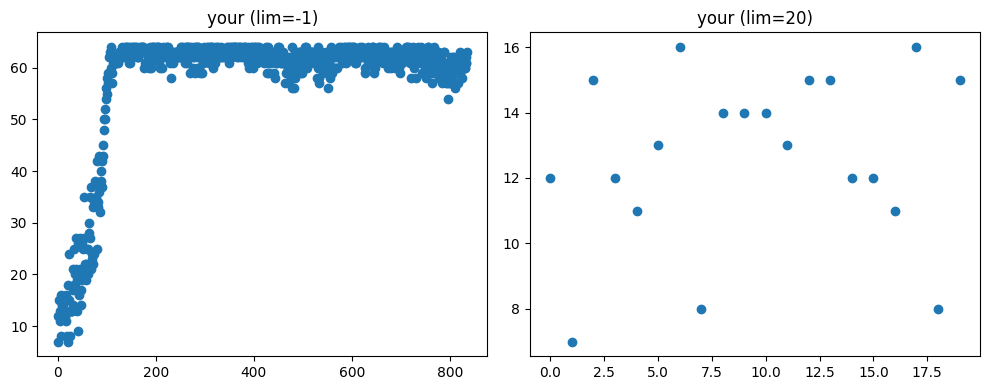

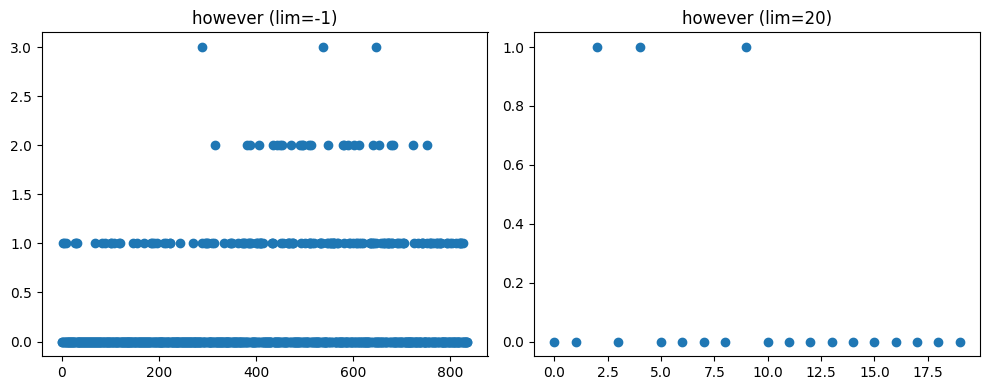

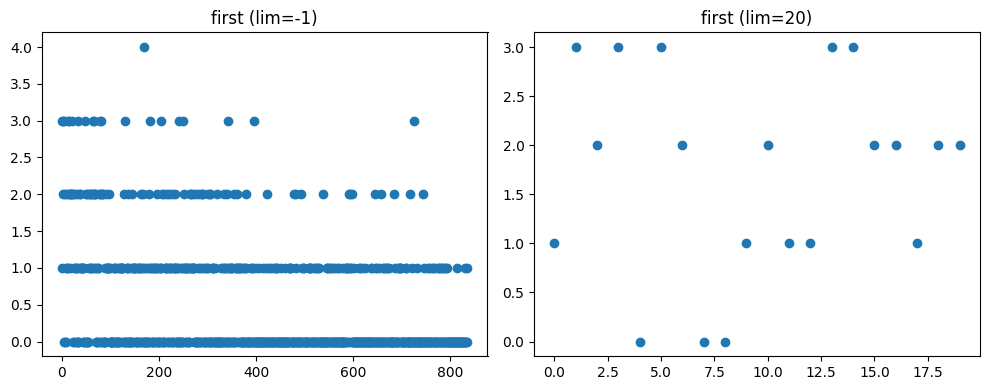

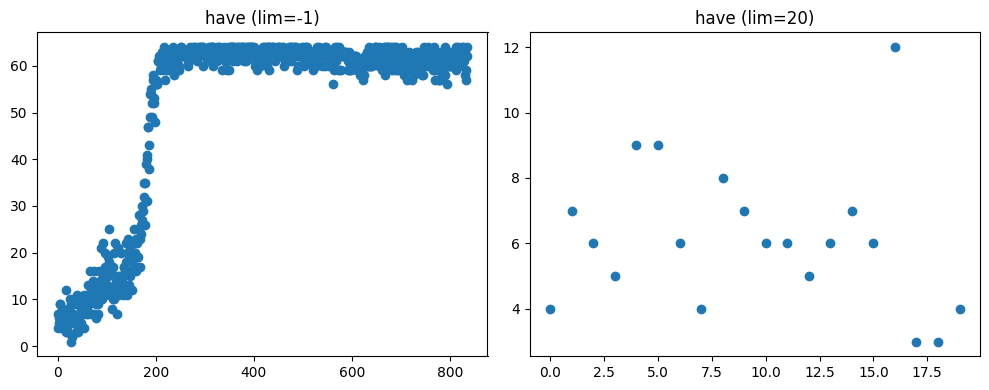

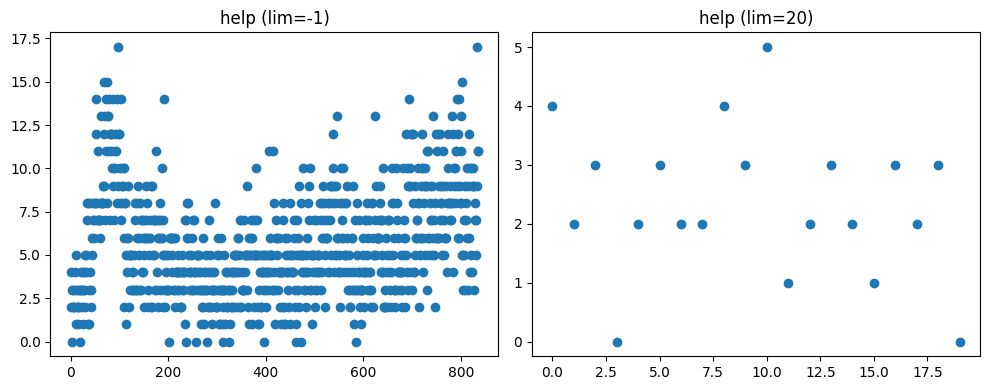

In [86]:
# Create plots for all words in bow_words
for word in bow_words:
    plt.figure(figsize=(10, 4))

    # Plot with lim = -1 (which I assume means no limit)
    plt.subplot(1, 2, 1)
    plt.scatter(list(range(len(nountrain))), word_scatter(word, unlist))
    plt.title(f"{word} (lim=-1)")

    # Plot with lim = 20
    plt.subplot(1, 2, 2)
    plt.scatter(list(range(20)), word_scatter(word, unlist)[:20])
    plt.title(f"{word} (lim=20)")

    plt.tight_layout()
    plt.show()

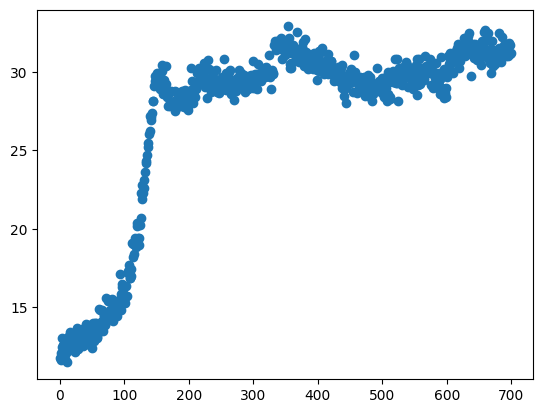

In [7]:
plt.scatter(list(range(len(nountrain))),[mean(get_synth_rewards(o, "nouns")) for o in nountrain['outputs']])

In [17]:
import pickle

In [36]:
with open("../../outputs/evalpickles/checkpoints_Natural", "rb") as f: 
    e = pickle.load(f)

UnpicklingError: invalid load key, '{'.

In [27]:
predictions = np.argmax(e[0], axis=0)
labels = np.zeros(e[0].shape)

AttributeError: 'tuple' object has no attribute 'shape'

In [34]:
e[0][0].shape

(274, 1)